# LISTA 1

## GLOBAL SETUP

In [1]:
import numpy as np
import os
import statistics
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from sys import getsizeof
import sys
import copy
import nltk
import collections
import random
import itertools

## ZADANIE 1

In [2]:
def Succ1Grams():
    data = set()
    
    #num_lines = sum(1 for line in open('poleval_2grams.txt'))
    num_lines = 59134224
    lines_read = 0
    with open("poleval_2grams.txt", "r") as f:
        with tqdm(total=num_lines) as pbar:
            line = f.readline()
            while line:
                if lines_read > 10000:
                    pbar.update(lines_read)
                    lines_read = 0
                    pbar.set_description(f"memory used {sys.getsizeof(data)/1024/1024} MB")
                lines_read += 1
                wc, wl, wp = line.replace("\n", "").split(" ")
                data.add(wl)
                data.add(wp)

                #if len(t) < 50:
                #    data.append(t)
                line = f.readline()
                if len(data) > 10000000:
                    break
    return data

singletons = Succ1Grams()
maxlen = max(len(s) for s in singletons)
print(f"read {len(singletons)}, longest one is {maxlen}")
maxlen = 25


read 3591116, longest one is 125


In [3]:
def OwnMatch(w):
    graph = [[] for _ in w]
    for slit in range(len(w)):
        for forward_succ in range(5):
            taken = w[slit:slit+forward_succ+1]
            if len(taken) == forward_succ+1:
                if taken in singletons:
                    graph[slit].append(slit + forward_succ + 1)

    #print(f"neighbor matrix")
    #display(graph)

    dp = [(0, None) for _ in range(len(w)+1)]
    for i in range(len(w)-1):
        for jt in graph[i]:
            if dp[jt][0] < (dp[i][0] + (i-jt)**2):
                dp[jt] = (dp[i][0] + (i-jt)**2, i)

    #display(dp)

    baked = []
    ls = dp[-1][1]
    fs = len(w)
    while ls != None:
        baked.append(w[ls:fs])
        fs = ls
        ls = dp[ls][1]
        
    baked.reverse()
    
    return baked 

In [4]:
def MaxMatch(w, verbose = False):
    wp = w
    tokenized = []
    succ = 1
    best = (0, "reeee")
    
    while len(w) > 0:
        try_ = w[:succ]
        if try_ in singletons:
            if verbose:
                print(f"found candidate {try_}")
            best = (succ, try_) 

        succ += 1
        
        if succ > maxlen or try_ == w:
            if best[0] == 0:
                raise Exception(f"could not match {w[:succ]} in {wp}")
            else:
                if verbose:
                    print(f"longest match was {best[1]}")
                tokenized.append(best[1])
                if verbose:
                    print(f"transforming {w} -> {w[best[0]:]}")
                w = w[best[0]:]
                succ = 1
                best = (0, "reeee")
    return tokenized

In [5]:
# implementation stolen from https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/
# since jupyter considered that importing
# python-levenstein is on the same level as breaking the geneva
# convention

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

In [6]:
def perform_test(compare_string):
    digested = compare_string.replace(" ", "")
    p1 = " ".join(MaxMatch(digested))
    p2 = " ".join(OwnMatch(digested))
    s1 = levenshteinDistanceDP(compare_string, p1)
    s2 = levenshteinDistanceDP(compare_string, p2)
    #print(compare_string)
    #print(f"MaxMatch returned {p1}, score {s1}")
    #print(f"OwnCrap returned {p2}, score {s2}")
    return (s1, s2)

In [7]:
poem = '''Jedzie Wojtuś popod lasem, skrajem dąbrowy,
Wiezie se do domu laser, laser gazowy.
Pytali się go kolesie, po co to nabył?
- A bo właśnie stał w GS-ie, więc kupiłem go Teresie.
Dyć coś zawsze przywieźć chce się dla swej baby!
Jedzie Wojtuś popod lasem, po twardym dukcie.
Wiezie se do domu laser, czyta instrukcję.
A instrukcja jest ciekawa: Włączyć do prądu,
To ten laser wszystko skrawa, bez różnicy, stal czy trawa
I w ogóle jest zabawa prawie bez swądu.
Jedzie Wojtuś popod lasem, woła: Wio, wiśta!
Wiezie se do domu laser, tak se rozmyśla:
Jak w tym dojdę do biegłości, będzie wygodnie,
Jest tu paru wrednych gości, przyceluję se w skrytości
I padalcom z odległości podpalę spodnie!
Jedzie Wojtuś popod lasem, rad, że o rany
Wiezie se do domu laser, układa plany:
Niech spróbuje na rowerze jeździć Kaczmarski,
Zaraz w dętkę mu przymierzę, i kartofle się obierze,
I wywierci dziury w serze, by był śwajcarski!
Jedzie Wojtuś popod lasem, skręcił przy POM-ie.
Wiezie se do domu laser schowany w słomie.
Na podwórku cielę bryka, kaczki na stawie...
Wdziera, wdziera się technika coraz częściej w dom rolnika,
Jeszcze to nie Ameryka.... Ale już prawie!!! '''

tMM, tMC = [], []
for l in tqdm(poem.split("\n")):
    retMM, retMC = perform_test(l.lower().replace(",", ""))
    tMM.append(retMM)
    tMC.append(retMC)
    
print("MaxMatch:")
print(f"Mean: {statistics.mean(tMM)}")
print(f"Stdev: {statistics.stdev(tMM)}")
print(f"max: {max(tMM)}")
print(f"min: {min(tMM)}")

print("MyCrap:")
print(f"Mean: {statistics.mean(tMC)}")
print(f"Stdev: {statistics.stdev(tMC)}")
print(f"max: {max(tMC)}")
print(f"min: {min(tMC)}")


#MaxMatch:
#Mean: 5.96
#Stdev: 4.6141087980237305
#max: 17.0
#min: 0.0
#MyCrap:
#Mean: 13.68
#Stdev: 12.294036494712927
#max: 48.0
#min: 4.0


MaxMatch:
Mean: 5.6
Stdev: 3.547299442298794
max: 12.0
min: 0.0
MyCrap:
Mean: 17.8
Stdev: 16.91646141090585
max: 48.0
min: 3.0


## ZADANIE 2 i 3


In [8]:
def calculate_bigrams():
    ins = collections.defaultdict(lambda: 0)
    bigrams = collections.defaultdict(lambda: copy.deepcopy(ins))
    num_lines = 59134224
    lines_read = 0
    maxim = 0
    with open("poleval_2grams.txt", "r") as f:
        with tqdm(total=num_lines) as pbar:
            line = f.readline()
            while line:
                if lines_read > 10000:
                    pbar.update(lines_read)
                    lines_read = 0
                    pbar.set_description(f"memory used {sys.getsizeof(bigrams)/1024/1024} MB")
                lines_read += 1
                wc, wl, wp = line.replace("\n", "").split(" ")
                if int(wc) > 2:
                    bigrams[wl][wp] += int(wc)
                    maxim = max(bigrams[wl][wp], maxim)

                line = f.readline()
                if len(bigrams) > 10000000:
                    break
    
    for w1 in bigrams.keys():
        for w2 in bigrams[w1].keys():
            bigrams[w1][w2] = float(bigrams[w1][w2])/float(maxim)
    return bigrams
            
bigrams = calculate_bigrams()
bigrams['kamienie']

defaultdict(<function __main__.calculate_bigrams.<locals>.<lambda>()>,
            {'naturalne': 1.4428801272504842e-06,
             'oznaczone': 1.4428801272504842e-07,
             'mogły': 2.40480021208414e-07,
             'półszlachetne': 1.1062080975587046e-06,
             'spod': 1.4428801272504842e-07,
             'kolorowe': 1.4428801272504842e-07,
             'jubilerskie': 2.40480021208414e-07,
             'znajdują': 1.923840169667312e-07,
             'oszlifowane': 1.923840169667312e-07,
             'szlachetne': 8.22441672532776e-06,
             'użyte': 1.4428801272504842e-07,
             'to': 7.214400636252421e-07,
             'wykorzystywane': 1.923840169667312e-07,
             '(': 1.490976131492167e-06,
             ':': 2.3567042078424576e-06,
             'w': 4.040064356301356e-06,
             'podgrzewane': 3.3667202969177965e-07,
             'dla': 1.923840169667312e-07,
             'ozdobne': 9.138240805919733e-07,
             'wołać': 2.8857602

In [9]:
import time
def generate_story(max_len, starting, distribution):
    if max_len == 0:
        max_len = 1000000
    if starting == None:
        starting = "<BOS>"
        
    while(max_len > 0):
        print(starting, end = ' ')
        max_len -= 1
        candidates = bigrams[starting]
        
        if distribution == "random":
            candidates = [i[0] for i in candidates.items()]
            if len(candidates) == 0:
                return
            starting = random.choice(candidates) 
            
        if distribution == "weight":
            if len([i[0] for i in candidates.items()]) == 0:
                return
            
            pscale = 1.0/sum(i[1] for i in candidates.items())
            starting = np.random.choice([i[0] for i in candidates.items()], p=[pscale * i[1] for i in candidates.items()])

In [10]:
for i in range(10):
    generate_story(0, None, "weight")
    print("\n=======")

<BOS> pani ewa kopacz , pozostawiając po 2 przyjął . <EOS> 
<BOS> o które trafiają one dość szybko jak np. archiwum . <EOS> 
<BOS> teraz wszystkie sprawy . <EOS> 
<BOS> czy przewiduje minister w działania niepożądane ) . <EOS> 
<BOS> zobaczyłam tę funkcję tzw. dotacja podmiotowa jest z pokazywaniem , o 10 ministrów nie przegapią 
<BOS> wielokrotnie zapowiadał na szczęście , aby móc się niczemu winni być automatyczne ) są niepotrzebne . 32 ) oraz hutę baildon sa , w czwartym . <EOS> 
<BOS> gra warta , zamordowana , . <EOS> 
<BOS> w encyklice evangelium vitae ) był to był jedynie oryginalny - zgody na tym tygodniu nie usunie ? <EOS> 
<BOS> realizując je popiera przedłożony radzie zostanie kamień pomorski , uprzejmie proszę zmierzać . <EOS> 
<BOS> kryzys i wreszcie chcę tu linii kolejowych nie dyskutowaliśmy tu w przepisach . <EOS> 


## ZADANIE 4

In [11]:
def calculate_sufix(suflen):
    ins = collections.defaultdict(lambda: 0)
    sufgrams = collections.defaultdict(lambda: copy.deepcopy(ins))
    procd = 0
    pbar = tqdm(total=len(bigrams.keys()))
    
    for w1 in bigrams.keys():
        procd += 1

        if procd > 1000:
            procd = 0
            pbar.update(1000)
            pbar.set_description(f"memory used {str(sys.getsizeof(sufgrams)/1024/1024)[:5]} MB")

        if len(w1) > suflen:
            pref_sufix = str(w1)[-suflen:]
            for w2 in bigrams[w1].keys():
                if len(str(w2)) > suflen:
                    suf_sufix = str(w2)[-suflen:]
                    sufgrams[pref_sufix][suf_sufix] += bigrams[w1][w2]
                    
    # normalize ...
    biggest = 0
    for w1 in sufgrams.keys():
        for w2 in sufgrams[w1].keys():
            biggest = max(biggest, sufgrams[w1][w2])
    print(f"maximum score was {biggest}")
    for w1 in sufgrams.keys():
        for w2 in sufgrams[w1].keys():
            sufgrams[w1][w2] = float(sufgrams[w1][w2])/float(biggest)
    
    pbar.close()
    return sufgrams

In [12]:
bigram_suflist = [calculate_sufix(i) for i in range(1, 6)]

maximum score was 0.30078178130967553



maximum score was 0.09357313295628578



maximum score was 0.04880373694410105



maximum score was 0.012760014213331365



maximum score was 0.00618716617765856



In [13]:
def succ_3grams():
    ins = collections.defaultdict(lambda: 0)
    insd = collections.defaultdict(lambda: copy.deepcopy(ins))
    trigrams = collections.defaultdict(lambda: copy.deepcopy(insd))
    
    num_lines = 179473348
    lines_read = 0
    mv = 0
    with open("poleval_3grams.txt", "r") as f:
        with tqdm(total=num_lines) as pbar:
            line = f.readline()
            while line:
                if lines_read > 10000:
                    pbar.update(lines_read)
                    lines_read = 0
                    pbar.set_description(f"memory used {sys.getsizeof(trigrams)/1024/1024} MB")

                lines_read += 1
                try:
                    wc, w1, w2, w3 = line.replace("\n", "").split(" ")
                    if int(wc) > 1:
                        trigrams[w1][w2][w3] += int(wc)
                        mv = max(mv, trigrams[w1][w2][w3])
                except Exception:
                    pass
                line = f.readline()
 
    return (trigrams, mv)
            
trigrams, max_c = succ_3grams()
print(f"normalize by {max_c}")
for w1 in trigrams.keys():
    for w2 in trigrams[w1].keys():
        for w3 in trigrams[w1][w2].keys():
            trigrams[w1][w2][w3] = float(trigrams[w1][w2][w3])/float(max_c)

trigrams['kamienie']


normalize by 762373


defaultdict(<function __main__.succ_3grams.<locals>.<lambda>()>,
            {'i': defaultdict(<function __main__.succ_3grams.<locals>.<lambda>()>,
                         {'jest': 3.9350816463856934e-06,
                          'skały': 6.5584694106428215e-06,
                          'drewno': 2.6233877642571285e-06,
                          'inne': 7.870163292771387e-06,
                          'butelki': 2.6233877642571285e-06,
                          'cegły': 5.246775528514257e-06,
                          'diamenty': 2.6233877642571285e-06,
                          'lawiny': 2.6233877642571285e-06,
                          'woda': 2.6233877642571285e-06,
                          'metale': 3.9350816463856934e-06,
                          'żwir': 2.6233877642571285e-06,
                          'koktajle': 5.246775528514257e-06,
                          'krzyż': 2.6233877642571285e-06,
                          'korzenie': 6.5584694106428215e-06,
                   

In [14]:
def calculate_sufix_3gram(suflen):
    ins = collections.defaultdict(lambda: 0)
    insd = collections.defaultdict(lambda: copy.deepcopy(ins))
    sufgrams = collections.defaultdict(lambda: copy.deepcopy(insd))
    procd = 0
    pbar = tqdm(total=len(trigrams.keys()))
    
    for w1 in trigrams.keys():
        procd += 1

        if procd > 1000:
            procd = 0
            pbar.update(1000)
            pbar.set_description(f"memory used {str(sys.getsizeof(sufgrams)/1024/1024)[:5]} MB")

        if len(w1) > suflen:
            pref_sufix = str(w1)[-suflen:]
            for w2 in trigrams[w1].keys():
                if len(str(w2)) > suflen:
                    suf_sufix = str(w2)[-suflen:]
                    for w3 in trigrams[w1][w2].keys():
                        if len(str(w3)) > suflen:
                            suf_suf_sufix = str(w3)[-suflen:]
                            sufgrams[pref_sufix][suf_sufix][suf_suf_sufix] += trigrams[w1][w2][w3]
                    
    # normalize ...
    biggest = 0
    for w1 in sufgrams.keys():
        for w2 in sufgrams[w1].keys():
            for w3 in sufgrams[w1][w2].keys():
                biggest = max(biggest, sufgrams[w1][w2][w3])
    print(f"maximum score was {biggest}")
    for w1 in sufgrams.keys():
        for w2 in sufgrams[w1].keys():
            for w3 in sufgrams[w1][w2].keys():
                sufgrams[w1][w2][w3] = float(sufgrams[w1][w2][w3])/float(biggest)
    
    pbar.close()
    return sufgrams

In [15]:
trigram_suflist = [calculate_sufix_3gram(i) for i in range(1, 6)]

maximum score was 1.1575646042039072



maximum score was 0.2358399366188816



maximum score was 0.0691183974248839



maximum score was 0.03963807742404309



maximum score was 0.03703961184354644



In [16]:
def calculate_score(results, desired):
    for resit, res in enumerate(results):
        if desired == " ".join(res[1:-1]):
            return 1.0/(resit + 1.0)
    return 0.0

In [17]:
def check_for_bigram(wa, wb):
    return bigrams[wa][wb]

def check_for_bisuf(wa, wb):
    for it in range(5, 1, -1):
        best = 0
        if len(wa) > it and len(wb) > it:
            sufa = wa[-it:]
            sufb = wb[-it:]
            if bigram_suflist[it-1][sufa][sufb] > 0.0:
                return (bigram_suflist[it-1][sufa][sufb], it)

def check_for_trigram(wa, wb, wc):
    if trigrams[wa][wb][wc] > 0:
        return trigrams[wa][wb][wc]
    return 0

def check_for_trisuf(wa, wb, wc):
    for it in range(5, 1, -1):
        best = 0
        if len(wa) > it and len(wb) > it:
            sufa = wa[-it:]
            sufb = wb[-it:]
            sufc = wc[-it:]
            if trigram_suflist[it-1][sufa][sufb][sufc] > 0.0:
                return (trigram_suflist[it-1][sufa][sufb][sufc], it)


def permutation_analizer(sentence, normalization = None):
    results = []
    norm_vals = [0.0, 0.0, 0.0]
    for pp in itertools.permutations(sentence):
        p = ["<BOS>"] + list(pp) + ["<EOS>"]
        score = 1.0
        taintcount = []
        for pit in range(len(p) - 1):
            # check for full trigram
            chunkscore = 0.0
            if pit < len(p) - 2:
                a1 = check_for_trigram(p[pit], p[pit+1], p[pit+2])
            # check for full bigram
            if pit < (len(p) - 1):
                a2 = check_for_bigram(p[pit], p[pit+1])
            
            # check for prefsizes.
            if pit < len(p) - 1:
                discore = check_for_bisuf(p[pit], p[pit+1])
            else:
                discore = None

            if pit < len(p) - 2:
                triscore = check_for_trisuf(p[pit], p[pit+1], p[pit+2])
            else:
                triscore = None

            if discore == None and triscore == None:
                a3 = 0.0
            elif discore == None and triscore is not None:
                a3 = triscore[0]
            elif discore is not None and triscore == None:
                a3 = discore[0]
            else:
                if discore[1] > triscore[1]:
                    a3 = discore[0]
                else:
                    a3 = triscore[1]
                
            if a1 + a2 + a3 == 0.0:
                taintcount.append(p[pit])
                chunkscore = 1e-100
            else: 
                if normalization is None:
                    chunkscore = a1+a2+a3
                else:
                    chunkscore = a1*normalization[0] + a2*normalization[1] + a3*normalization[2]
                    
            score *= chunkscore
            norm_vals = [
                max(norm_vals[vit], vi) for vit, vi in enumerate([a1, a2, a3])
            ]
        
        results.append((-score, p, taintcount))
    
    if normalization is not None:
        res = sorted(results)
        return res
        for r in res[:10]:
            print(r)
    else:
        print("that was the normalization pass, please rerun with this argument")

    return norm_vals
    
pres = permutation_analizer("wczoraj wieczorem spotkałem pewną piękną kobietę".split(" "), 
                     [1.0,
                      0.001,
                      0.000001,
                     ])

calculate_score(
    [i[1] for i in pres],
    "wczoraj wieczorem spotkałem pewną piękną kobietę")
#permutation_analizer(["judyta", "dała", "wczoraj", "stefanowi", "czekoladki"])

0.0030959752321981426

In [71]:
rundict = {}

def run_test_suite(norm = [1.0, 0.0, 0.0]):
    with open("test.txt", "r") as f:
        results = []
        for t in f.read().split("\n"):
            test = t.split(" ")
            response = permutation_analizer(test, norm)
            results.append(calculate_score([r[1] for r in response], t))
    return (statistics.mean(results), statistics.stdev(results))

norms = []
for i in [1000000000.0,100000000000.0, 1000000000000.0, 10000000000000.0, 1000000000000000.0]:
    for j in [1000000000.0,100000000000.0, 1000000000000.0, 10000000000000.0, 1000000000000000.0]:
        for k in [1.0]:
            norms.append([i, j, k])

blessed = []
for norm in tqdm(norms):
    if f"{norm[0]},{norm[1]},{norm[2]}" in rundict:
        blessed.append((rundict[f"{norm[0]},{norm[1]},{norm[2]}"], norm))
    else:
        print(f"dry run for {norm}")
        run = run_test_suite(norm)
        rundict[f"{norm[0]},{norm[1]},{norm[2]}"] = run
        blessed.append((run, norm))

display(sorted(blessed)[-5:])

In [18]:
best = [10000000000000.0, 1000000000.0, 1.0]
given = []
finished = []
with open("test.txt", "r") as f:
        results = []
        for t in tqdm(f.read().split("\n")):
            test = t.split(" ")
            response = permutation_analizer(test, best)
            s = calculate_score([r[1] for r in response], t)
            given.append(s)
            tries = []
            for score, ans, _ in response:
                tries.append(" ".join(ans[1:-1]))
                if t == " ".join(ans[1:-1]):
                    finished.append((len(tries), t, s, tries))
                    break
                    
print(statistics.mean(given))


0.30780482954995037


In [19]:
smap = collections.defaultdict(lambda: 0)
for l, t, s, tries in sorted(finished):
    smap[s] += 1
    print("--------------")
    print(f"computed {t} with score {s}")
    if len(tries) < 10:
        for tr in tries:
            print(tr)
    else:
        for tr in tries[:5]:
            print(tr)
        print(f"\n --- ommited {len(tries) - 10} failed attempts ---\n")
        for tr in tries[-5:]:
            print(tr)
        

--------------
computed czasem mogą pojawić się informacje o regułach with score 1.0
czasem mogą pojawić się informacje o regułach
--------------
computed dodatkowe zasady umożliwiające zwolnienie z egzaminu with score 1.0
dodatkowe zasady umożliwiające zwolnienie z egzaminu
--------------
computed dodatkowo coś mu się odejmuje with score 1.0
dodatkowo coś mu się odejmuje
--------------
computed dotyczą osób z dużą liczbą punktów with score 1.0
dotyczą osób z dużą liczbą punktów
--------------
computed forma egzaminu zależy od wielu czynników with score 1.0
forma egzaminu zależy od wielu czynników
--------------
computed hipoteza continuum jest niezależna od aksjomatów with score 1.0
hipoteza continuum jest niezależna od aksjomatów
--------------
computed jedną grupę prowadzi jakub michaliszyn with score 1.0
jedną grupę prowadzi jakub michaliszyn
--------------
computed ocenę wystawia się zgodnie z tabelką with score 1.0
ocenę wystawia się zgodnie z tabelką
--------------
computed pier

In [20]:
print(smap)

defaultdict(<function <lambda> at 0x7f3db25d3f70>, {1.0: 12, 0.5: 5, 0.3333333333333333: 9, 0.25: 1, 0.2: 2, 0.16666666666666666: 3, 0.14285714285714285: 1, 0.125: 2, 0.1: 1, 0.09090909090909091: 1, 0.08333333333333333: 1, 0.07692307692307693: 1, 0.07142857142857142: 1, 0.0625: 2, 0.05555555555555555: 1, 0.05: 1, 0.037037037037037035: 1, 0.034482758620689655: 1, 0.03333333333333333: 1, 0.03125: 1, 0.029411764705882353: 1, 0.023255813953488372: 1, 0.0196078431372549: 1, 0.018518518518518517: 1, 0.015384615384615385: 1, 0.015151515151515152: 1, 0.008130081300813009: 1, 0.008064516129032258: 1, 0.006993006993006993: 1, 0.006896551724137931: 1, 0.00641025641025641: 1, 0.0045871559633027525: 1, 0.0037593984962406013: 1, 0.0036101083032490976: 1, 0.0030864197530864196: 1, 0.002004008016032064: 1, 0.0003324468085106383: 1})


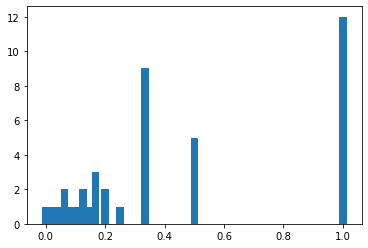

In [21]:
fig, ax = plt.subplots()
ax.bar([i[0] for i in smap.items()], [i[1] for i in smap.items()], width = 0.025)
plt.show()